In [20]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [21]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

In [22]:
trainset = datasets.MNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform=transform)
valset = datasets.MNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

In [23]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


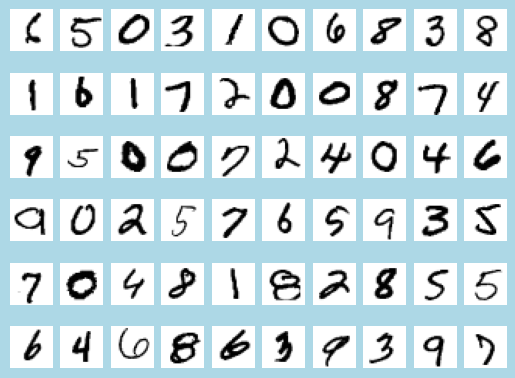

In [24]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [25]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


In [26]:
def labelTransform(labels:torch.Tensor,no_of_cls:int):
    ndArr = np.zeros((len(labels),no_of_cls))
    ndLbls = labels.numpy()
    for i, arr in enumerate(ndArr):
       arr[ndLbls[i]]=1
    return torch.tensor(ndArr,dtype=torch.float32) 

In [27]:

images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities

criterion = nn.CrossEntropyLoss()

#tlabls = labelTransform(labels,10)
loss = criterion(logps,labels) #calculate the loss


In [28]:
print('Before backward pass: \n', model[0].weight.grad)
loss.backward()
print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[-0.0019, -0.0019, -0.0019,  ..., -0.0019, -0.0019, -0.0019],
        [ 0.0026,  0.0026,  0.0026,  ...,  0.0026,  0.0026,  0.0026],
        [-0.0005, -0.0005, -0.0005,  ..., -0.0005, -0.0005, -0.0005],
        ...,
        [-0.0009, -0.0009, -0.0009,  ..., -0.0009, -0.0009, -0.0009],
        [ 0.0015,  0.0015,  0.0015,  ...,  0.0015,  0.0015,  0.0015],
        [ 0.0017,  0.0017,  0.0017,  ...,  0.0017,  0.0017,  0.0017]])


In [35]:
optimizer = optim.Adam(model.parameters(), lr=0.003)
time0 = time()
epochs = 15
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 0.20512593241690447
Epoch 1 - Training loss: 0.14738832965596463
Epoch 2 - Training loss: 0.1267385509419642
Epoch 3 - Training loss: 0.11323537834252773
Epoch 4 - Training loss: 0.10964491397047094
Epoch 5 - Training loss: 0.10154867293521651
Epoch 6 - Training loss: 0.09186393662784269
Epoch 7 - Training loss: 0.08959620959137374
Epoch 8 - Training loss: 0.08664613870902857
Epoch 9 - Training loss: 0.08591702566716074
Epoch 10 - Training loss: 0.07648087354344148
Epoch 11 - Training loss: 0.07701399785651168
Epoch 12 - Training loss: 0.07266554750215663
Epoch 13 - Training loss: 0.069860833166326
Epoch 14 - Training loss: 0.06980537170338741

Training Time (in minutes) = 2.960072910785675


In [36]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

Predicted Digit = 9


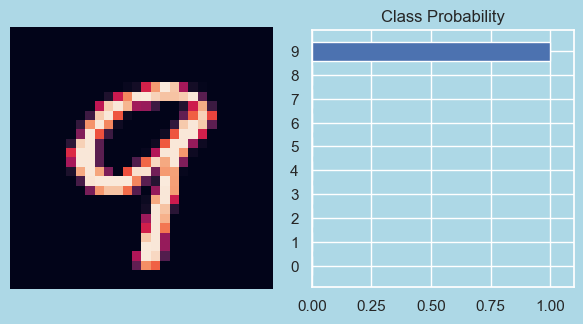

In [37]:
images, labels = next(iter(valloader))

img = images[0].view(1, 784)
with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)

In [38]:
correct_count, all_count = 0, 0
pred_label_arr = []
true_label_arr =[]
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    # Turn off gradients to speed up this part
    with torch.no_grad():
        logps = model(img)

    # Output of the network are log-probabilities, need to take exponential for probabilities
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1
    pred_label_arr.append(pred_label)
    true_label_arr.append(true_label)
print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.9689


In [39]:
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'axes.facecolor': 'lightblue', 'figure.facecolor': 'lightblue'})


def confusionMatrixAndAccuracyReport(Y_test, Y_pred):
    cm = metrics.confusion_matrix(Y_test, Y_pred)
    overallAccuracy = np.trace(cm)/sum(cm.flatten())

    classwiseAccuracy = np.zeros(len(cm))
    for n in range(len(cm)):
        for i in range(len(cm)):
            for j in range(len(cm)):
                if (i != n and j != n) or (i == n and j == n):
                    classwiseAccuracy[n] += cm[i][j]

    classwiseAccuracy /= sum(cm.flatten())

    plt.figure(figsize=(6, 6))
    plt.title('Accuracy Score: {0:3.3f}'.format(overallAccuracy), size=12)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    sns.heatmap(data=cm, annot=True, square=True,  cmap='Blues')

    plt.show()
    print('Overall Accuracy Score: {0:3.3f}'.format(overallAccuracy))
    print('Classwise Accuracy Score: {0}'.format(classwiseAccuracy))


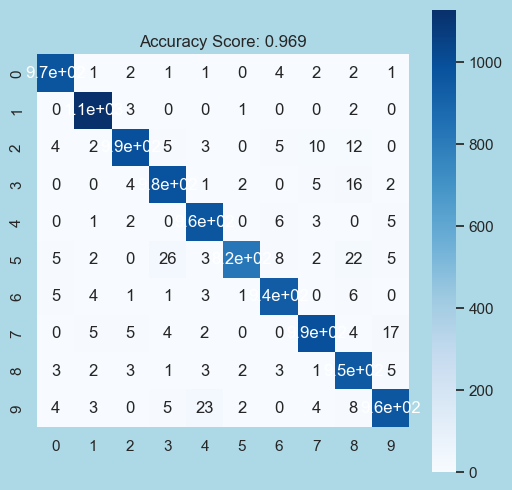

Overall Accuracy Score: 0.969
Classwise Accuracy Score: [0.9965 0.9974 0.9939 0.9927 0.9944 0.9919 0.9953 0.9936 0.9905 0.9916]


In [40]:

confusionMatrixAndAccuracyReport(true_label_arr,pred_label_arr)